In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import dask
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [2]:
grid = vcm.catalog.catalog["grid/c48"].to_dask()

In [3]:
def get_mse_bias(prediction, target):
    diff = prediction - target
    dims = ["tile", "x", "y", "z"]
    dims = set(diff.dims) & set(dims)
    bias = vcm.weighted_average(diff, grid.area, dims=dims)
    mse = vcm.weighted_average(diff ** 2, grid.area, dims=dims)
    return mse, bias


def _get_pred_targ_keys(varname):
    base = "tendency_of_{varname}_due_to_zhao_carr_{source}"
    pr_base = "surface_precipitation_due_to_zhao_carr_{}"

    if "precipitation" in varname:
        return pr_base.format("emulator"), pr_base.format("physics")
    else:
        return (
            base.format(varname=varname, source="emulator"),
            base.format(varname=varname, source="physics")
        )

def _get_field_metrics(pred_ds, targ_ds, fields, key_func):

    ds = xr.Dataset()
    for f in fields:
        p_key, t_key = key_func(f)
        mse, bias = get_mse_bias(pred_ds[p_key], targ_ds[t_key])
        ds[f"mse.{f}"] = mse
        ds[f"bias.{f}"] = bias

    return ds

def get_all_vars_metrics(pred_ds, targ_ds):
    fields = ["air_temperature", "specific_humidity", "cloud_water", "surface_precipitation"]

    return _get_field_metrics(pred_ds, targ_ds, fields, _get_pred_targ_keys)


def get_all_baseline_metrics(online_ds, offline_ds):

    fields = [
        "air_temperature",
        "specific_humidity",
        "cloud_water_mixing_ratio",
        "total_precipitation",
        "h500",
        "USWRFtoa",
        "ULWRFtoa",
        "PWAT",
    ]

    return _get_field_metrics(online_ds, offline_ds, fields, lambda x: (x, x))



In [4]:
base_prefix = "zc-emu-monthly-normfix-m{init}-seed3-30d-v1"

In [5]:
def _open_group_pairs(prefix):

    online = common.open_group(f"{prefix}-online")
    offline = common.open_group(f"{prefix}-offline")

    return online, offline

groups = [base_prefix.format(init=f"{i:02d}") for i in range(1, 13)]
jobs = [delayed(_open_group_pairs)(g) for g in groups]
opened = Parallel(n_jobs=12)(jobs)

In [6]:
prefix_opened_map = {prefix: handles for prefix, handles in zip(groups, opened)}

In [7]:
client = dask.distributed.Client()

/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43793 instead
  warnings.warn(


In [8]:
@common.memoize_xarray_out
def get_group_mse_bias_metrics(group):

    online, offline = prefix_opened_map[group]

    ds = xr.Dataset()
    online_metr = get_all_vars_metrics(online, online)
    for k, v in online_metr.items():
        ds[f"online.{k}"] = v
    
    diag_metr = get_all_vars_metrics(online, offline)
    for k, v in diag_metr.items():
        if "mse" not in k:
            ds[f"diagnostic.{k}"] = v

    offline_metr = get_all_vars_metrics(offline, offline)
    for k, v in offline_metr.items():
        ds[f"offline.{k}"] = v

    return ds.load()


In [9]:
results = [
    get_group_mse_bias_metrics(base_prefix.format(init=f"{i:02d}")) 
    for i in range(1, 13)
]

In [10]:
to_concat = [ds.drop_vars("time") for ds in results]

In [11]:
ds = xr.concat(to_concat, dim="init")

In [12]:
dt = 900 # s
seconds_per_day = 60 * 60 * 24  # seconds/min * min/hr * hr/day
m_to_mm = 1000

# from physcons.f
cp = 1.0046e3 # J / (kg K)
gravity = 9.80665 # m / s^2
lv = 2.5e6  # J / kg water
rho_water = 1000.0 # kg / m^3

def kg_m2_s_to_mm_day(da):
    return da * seconds_per_day / rho_water * m_to_mm

In [13]:
scale_factors = {
    "air_temperature": seconds_per_day, # seconds per day
    "specific_humidity": seconds_per_day * 1000,
    "cloud_water": seconds_per_day * 1000,
    "surface_precipitation": seconds_per_day / rho_water * m_to_mm,
}

units = {
    "air_temperature": "K/day", # seconds per day,
    "specific_humidity": "g/kg/day",
    "cloud_water": "g/kg/day",
    "surface_precipitation": "mm/day",
}

In [14]:
def plot_var_stats(ds, field):
    for_table = xr.Dataset()
    fig, ax = plt.subplots(1, 2, dpi=120, figsize=(8,4), constrained_layout=True)
    for k, v in ds.items():
        run, metric, f = k.split(".")
        da = ds[k]
        if field == f:
            if metric == "mse":
                da = np.sqrt(da)
                metric = "rmse"
                da = da * scale_factors.get(field, 1)
                da.mean(dim="init").plot(label=f"{run}", ax=ax[0])
                ax[0].set_title(f"{field} {metric}")
                ax[0].set_ylabel(units[field])
                ax[0].legend()
            if metric == "bias":
                da = da * scale_factors.get(field, 1)
                da.mean(dim="init").plot(label=f"{run}", ax=ax[1])
                ax[1].set_title(f"{field} {metric}")
                ax[1].set_ylabel(units[field])
                ax[1].legend()
            da.attrs["units"] = units[field]
            for_table[k] = da
    plt.legend()
    plt.show()
    return for_table

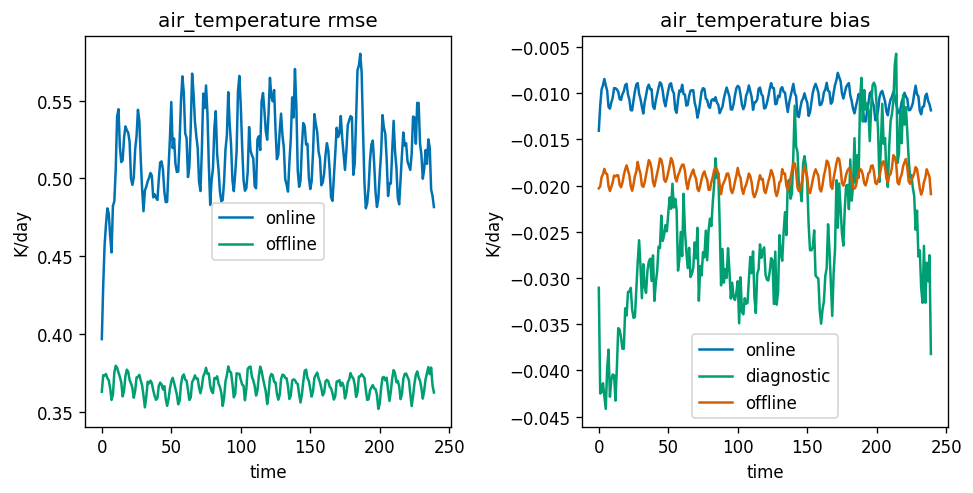

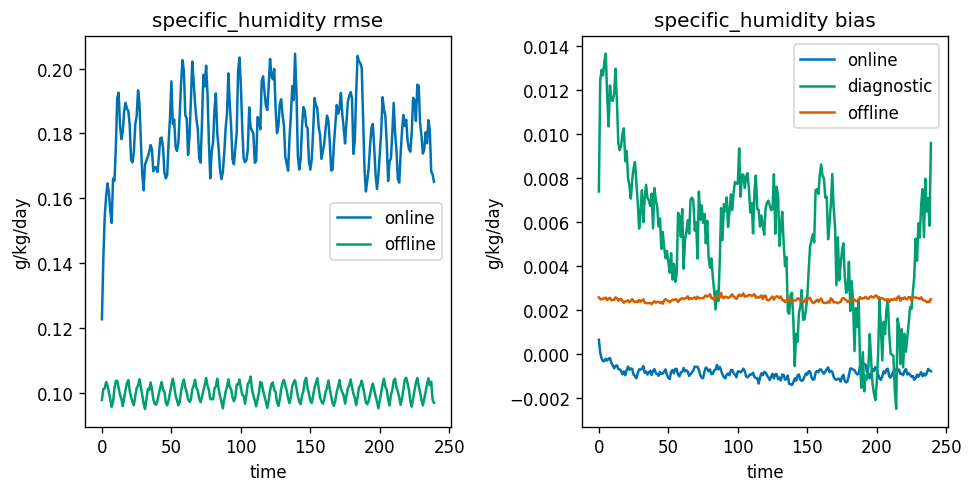

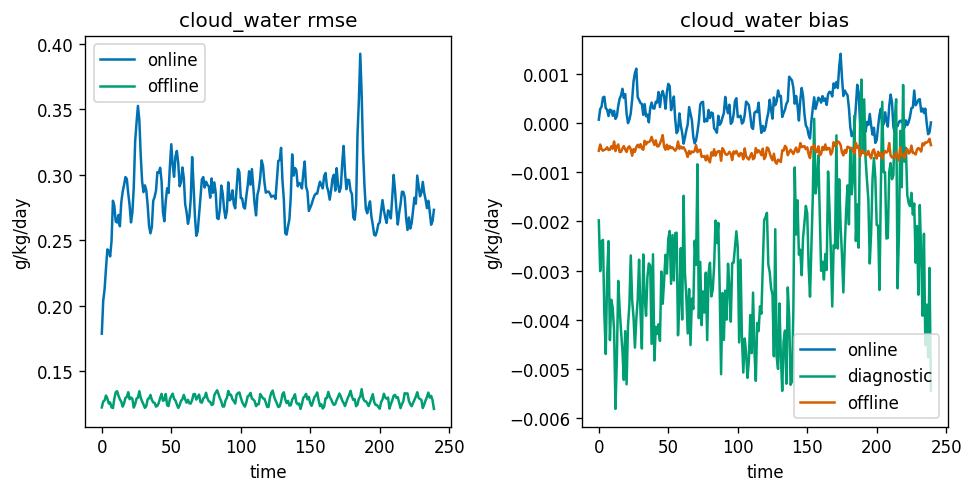

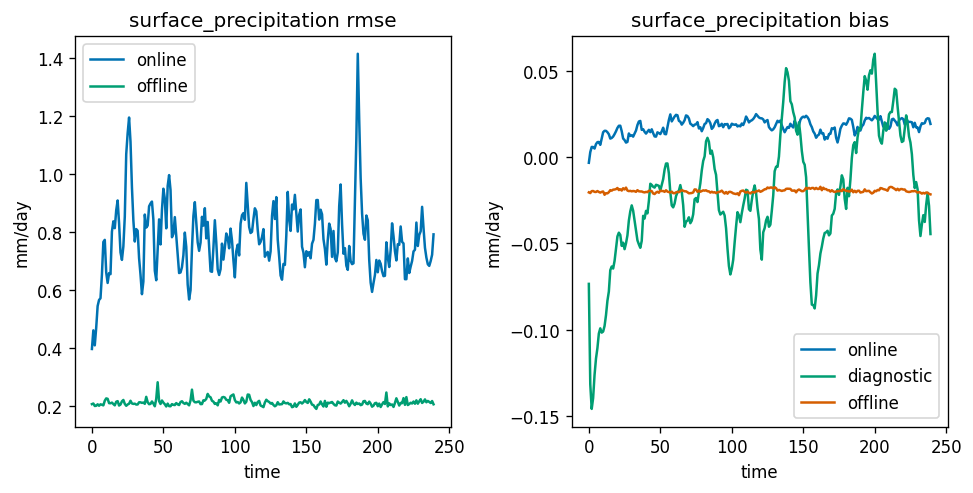

In [15]:

fields = ["air_temperature", "specific_humidity", "cloud_water", "surface_precipitation"]
metrics = xr.Dataset()
for field in fields:
    metrics = metrics.merge(plot_var_stats(ds, field))

In [16]:
metric_pd = metrics.mean().to_pandas()

In [17]:
items = []
for idx, val in metric_pd.iteritems():
    run, metr, field = idx.split(".")
    items.append((field, run, metr, val))
new_df = pd.DataFrame(items, columns=["field", "run_type", "metric_name", "value"])



In [18]:
new_df.pivot(index=["run_type", "metric_name"], columns="field", values="value")

field                   air_temperature  cloud_water  specific_humidity  \
run_type   metric_name                                                    
diagnostic bias               -0.025601    -0.002871           0.005149   
offline    bias               -0.019096    -0.000564           0.002485   
           mse                 0.367649     0.127980           0.100102   
online     bias               -0.010531     0.000246          -0.000859   
           mse                 0.515778     0.284725           0.180276   

field                   surface_precipitation  
run_type   metric_name                         
diagnostic bias                     -0.022310  
offline    bias                     -0.019664  
           mse                       0.211918  
online     bias                      0.017589  
           mse                       0.773997

In [19]:
@common.memoize_xarray_out
def get_group_baseline_metrics(group):

    online, offline = prefix_opened_map[group]

    ds = get_all_baseline_metrics(online, offline)

    return ds.load()   

In [20]:
results = [
    get_group_baseline_metrics(base_prefix.format(init=f"{i:02d}")) 
    for i in range(1, 13)
]

In [21]:
to_concat = [ds.drop_vars("time") for ds in results]
baseline_ds = xr.concat(to_concat, dim="init")

In [22]:
baseline_df = baseline_ds.mean().to_pandas()
items = []
for idx, val in baseline_df.iteritems():
    metr, field = idx.split(".")
    if metr == "bias":
        items.append((field, val))
baseline_df = pd.DataFrame(items, columns=["field", "value"])
baseline_df.set_index("field")

,value
field,
air_temperature,-9.467291e-02
specific_humidity,-1.252163e-06
cloud_water_mixing_ratio,1.526239e-07
total_precipitation,3.153312e-07
h500,-1.887780e+00
USWRFtoa,1.337382e+00
ULWRFtoa,-1.398786e+00
PWAT,-6.689321e-03


In [25]:
common.m_to_mm_day(3.153312e-07)

0.030271795200000003

In [26]:
1.337382 + -1.398786

-0.061404000000000014